# 6.6 Sourcing & Analyzing Time-Series Data

## Q1. Quadl Library Install


This has been installed using the conda.

## Q2. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

#### Data Sourcing: I have used the GDP data from the Federal Reserve Economic Data. Since, I couldn't find a data set that shared a  common key with my main dataset , I sourced a completely different dataset to understand this concept of analyzing the time series.

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'qaj8EhS5ycWuSLejZpJb'

In [3]:
# Importing the "GDP" variable.

data = quandl.get('FRED/GDP')

In [4]:
data.head(5)

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [5]:
data.shape

(300, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

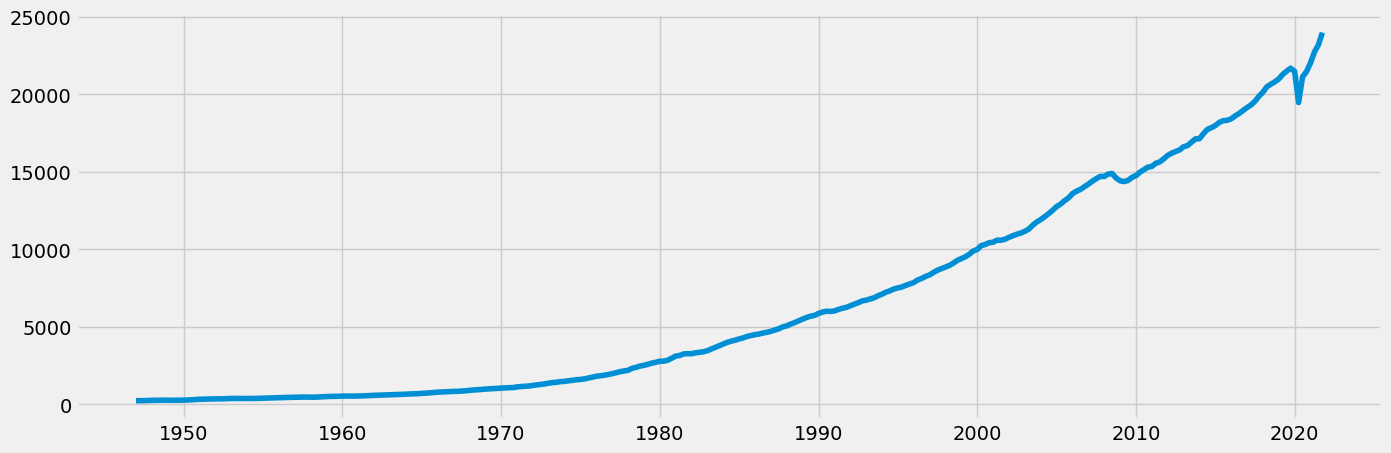

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## Q3  Subsetting, wrangling, and cleaning time-series data

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


I would want to consider the data post 1980. Before 1980, there was a post world war boom and period of Stagflation in 1970s. Hence, I am considering the era (post 1980s) that includes the tech boom of the late 20th century and increased globalization, which significantly impacted economic structures and growth patterns. It's a period of recovery, deregulation, and the beginning of the information age. Also, I will consider data till Jan 2020. Covid ht the world in late 2019 and hence, it would be better to consider the GDP calculated until Jan 2020.

In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-01-01')]

In [13]:
data_sub.shape

(160, 2)

In [14]:
data_sub.head()

,Date,Value
132,1980-01-01,2789.842
133,1980-04-01,2797.352
134,1980-07-01,2856.483
135,1980-10-01,2985.557
136,1981-01-01,3124.206


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,2789.842
1980-04-01,2797.352
1980-07-01,2856.483
1980-10-01,2985.557
1981-01-01,3124.206


## Q4. Line Chart of the Sub Dataset

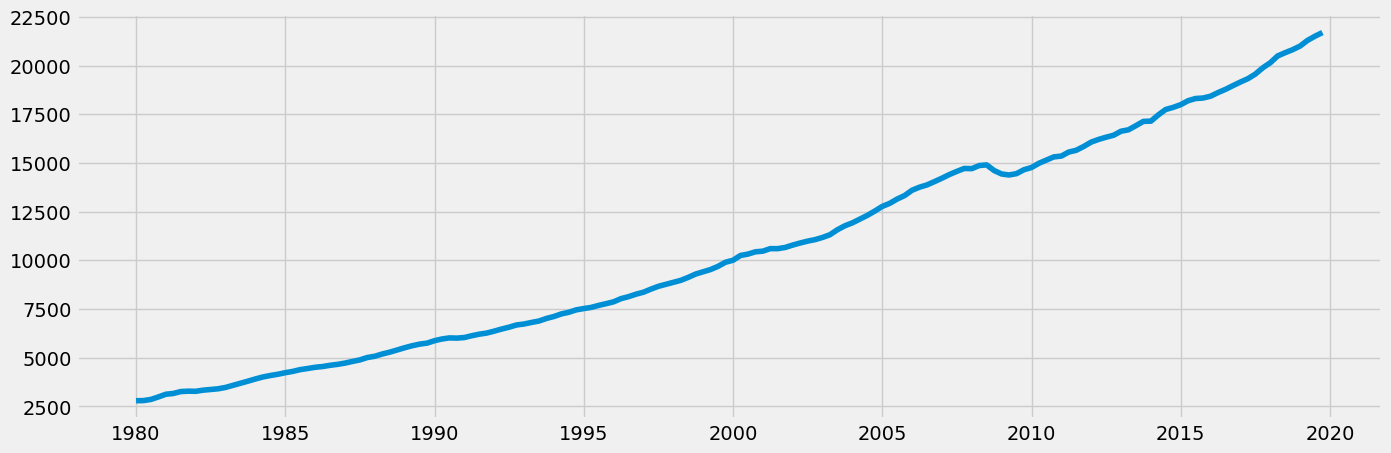

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

No missing values

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()


0

No duplicates

## Q5. Decomposition

In [23]:
# Decomposing using Additive model
# Changes in the data behave in a linear fashion and hence, I am using an additive model here.

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

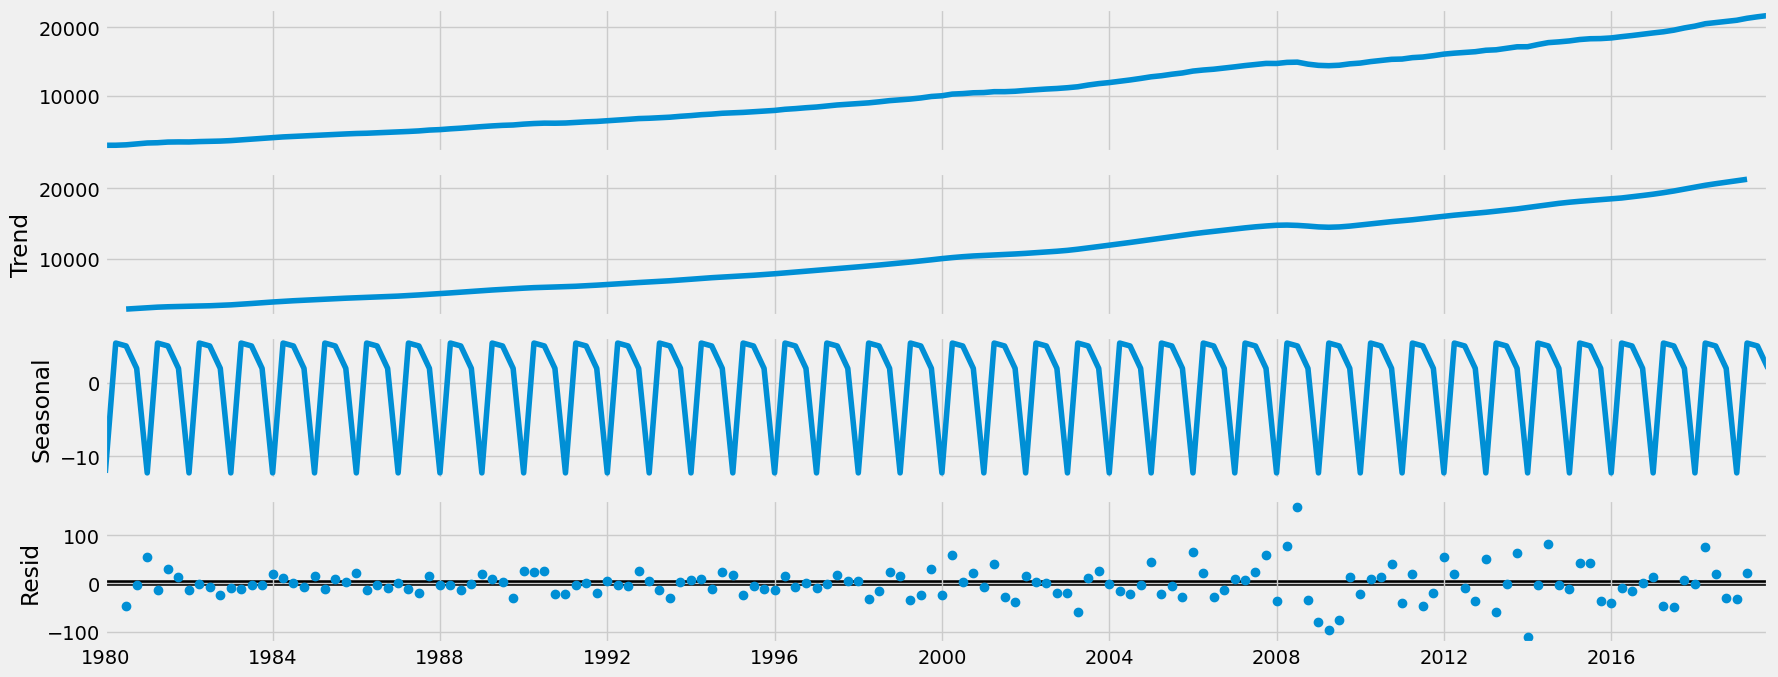

In [22]:
# Plotting the components

decomposition.plot()
plt.show()

1. The level and the data appear similar since there is hardly any noise in the dataset.
2. The middle plot illustrates the seasonal component. This is a repeating cycle that appears to be annual, given the regularity and number of cycles within the plotted time frame. The amplitude of the seasonal variations is consistent, implying that the seasonal influence on GDP has been stable over time. This seasonal effect could be due to various factors such as fiscal policies, holiday seasons, or industrial production cycles.
3. The bottom plot represents the residual component, which captures the irregularities in the data that are not explained by the trend or seasonal components. Ideally, in a well-decomposed time series, the residuals should appear as random noise, indicating that the model has captured the underlying pattern effectively. In this chart, the residuals seem to be mostly random around the zero line, with no apparent patterns, which suggests that the decomposition has done a good job. 

There are, however, a few outliers, which could represent unexpected economic events or shocks not accounted for by the trend or seasonal components.

## Q6. Checking for Stationarity

In [24]:

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.854540
p-value                          1.000000
Number of Lags Used              2.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


Given that the test statistic (2.854540) is greater than all the critical values and the p-value for significance level 5%, is high (1.000000), we fail to reject the null hypothesis of the presence of a unit root. This implies that the time series is non-stationary.

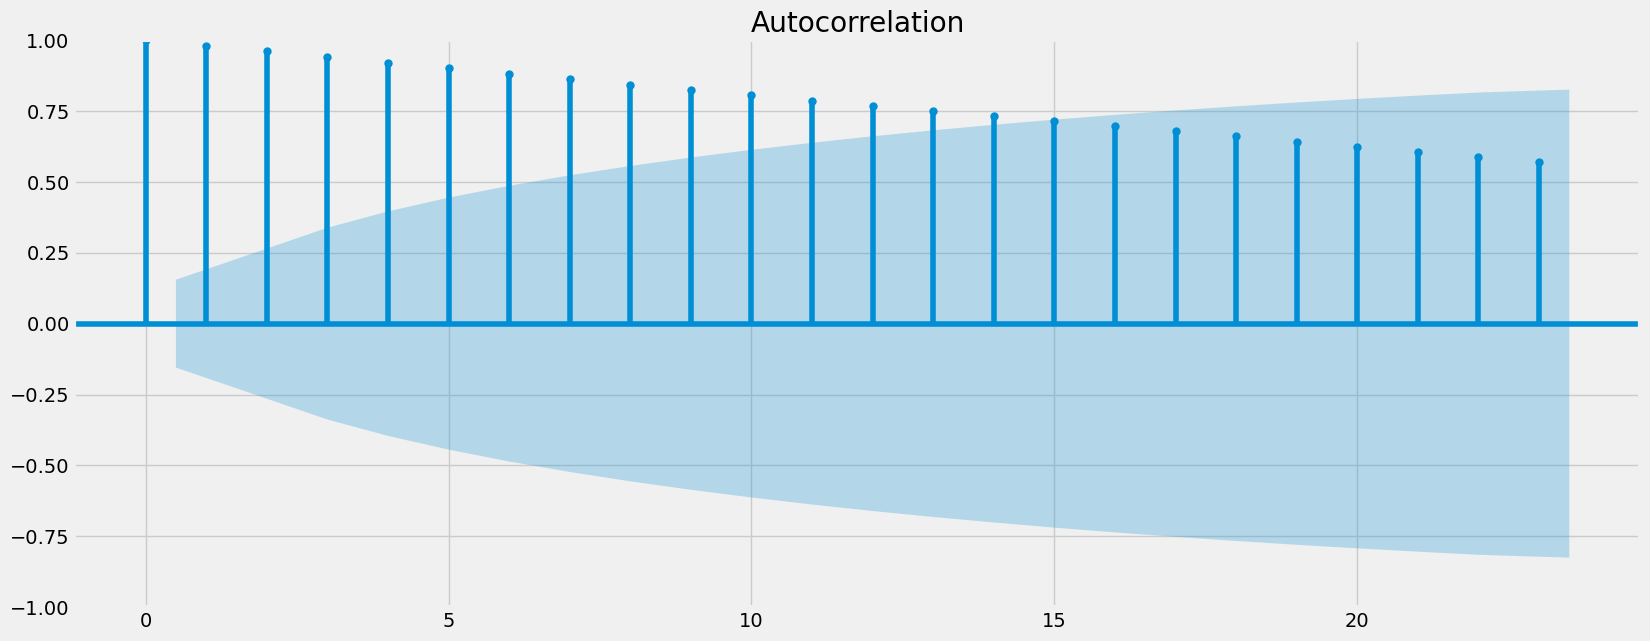

In [34]:
# A plot for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

## Q8. Stationarizing the Data

In [26]:
data_diff = data_sub - data_sub.shift(1)

In [28]:
# Removing missing values that might have come due to differencing.
data_diff.dropna(inplace = True)

In [29]:
data_diff.head()

,Value
datetime,
1980-04-01,7.510
1980-07-01,59.131
1980-10-01,129.074
1981-01-01,138.649
1981-04-01,38.326


In [30]:
data_diff.columns

Index(['Value'], dtype='object')

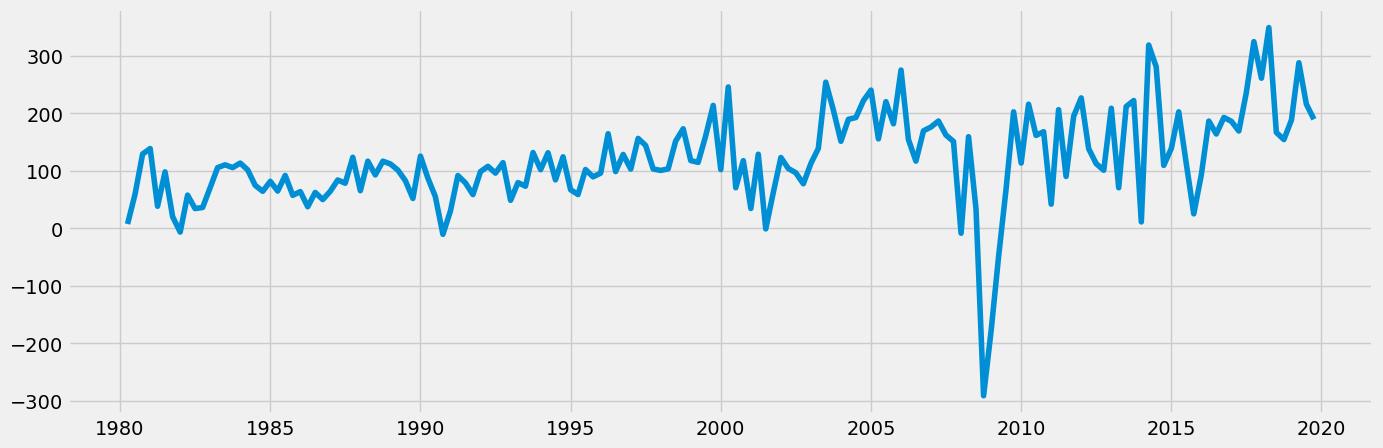

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.974208
p-value                          0.000025
Number of Lags Used              1.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


The test statistic is now smaller than the critical value at both the five and ten percent significance levels. We have a pvalue that is good (p<0.05). This means we can reject the null hypothesis and, as a result, consider our series as stationary.

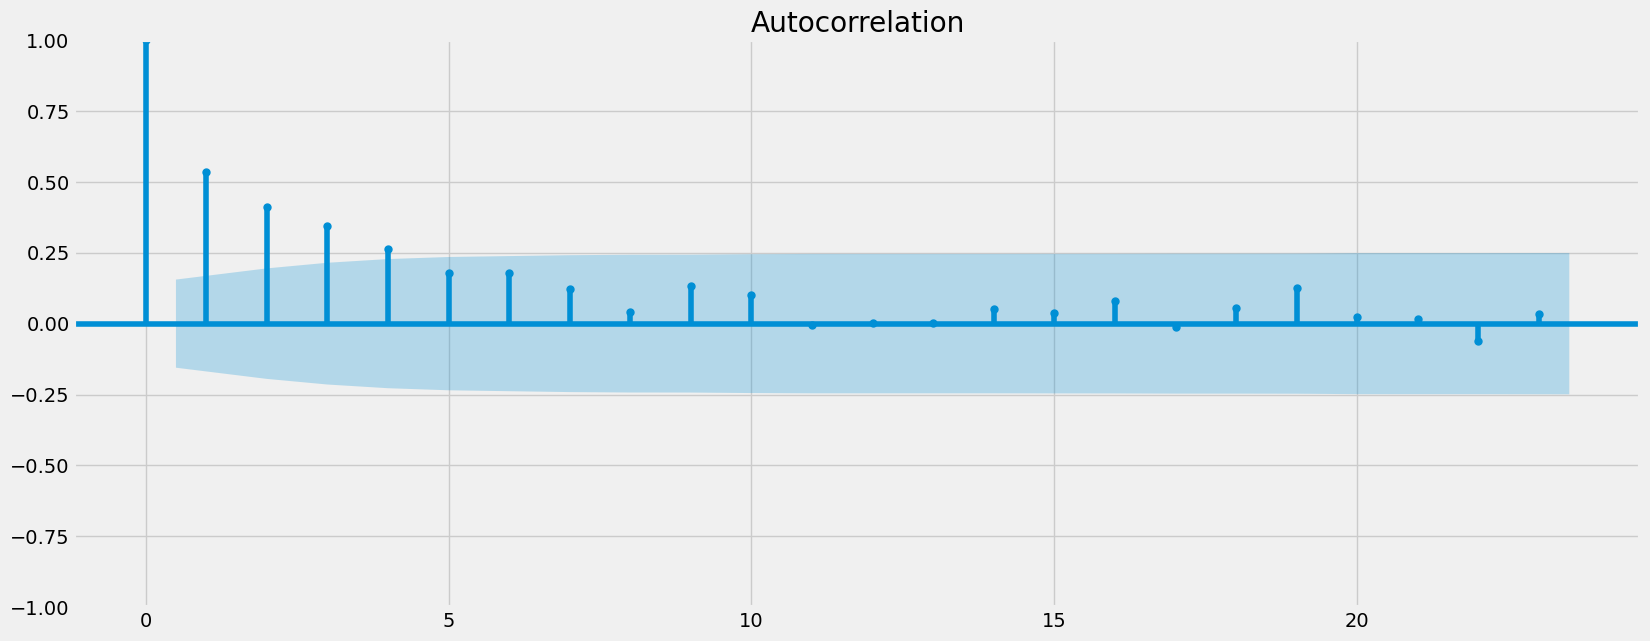

In [33]:
plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it is not yet perfect. The stationarity is in a medium range.The lags are less and hence, we donot need a second round of differencing.